# «Построение рекомендательной системы с помощью векторного представления графа знаний»
### Вид исследуемых данных:
###### Набор данных о пользователях музыкальной платформы Spotify


# Установка пакетов/библиотек

In [ ]:
%pip install "tensorflow-gpu>=1.15.2,<2.0"
import tensorflow as tf

In [ ]:
%pip install ampligraph

In [ ]:
import pandas as pd
import numpy as np
import time
import random 
from random import randint
from random import choices

from ampligraph.latent_features import ComplEx
from ampligraph.discovery import find_nearest_neighbours
from ampligraph.evaluation import evaluate_performance
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.utils.model_utils import dataframe_to_triples

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Обработка датасета

In [ ]:
start_time = time.time()
df1 = pd.read_csv('spotify_dataset.csv', dtype=str, on_bad_lines='skip', skiprows=1, names=['user_id', 'artist', 'track', 'playlist'])
#df1.info()
df2 = pd.read_csv('SpotifyFeatures.csv', on_bad_lines='skip')
df2 = df2.drop(columns=['track_id', 'danceability', 'energy', 'liveness', 'acousticness', 'duration_ms', 'instrumentalness', 'key', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'])
df2 = df2.drop_duplicates(subset=['artist_name', 'track_name']).reset_index(drop=True)
#df2.info()
df = pd.merge(df1, df2, left_on=['artist','track'], right_on =['artist_name', 'track_name'], how='inner')
df = df.drop(columns=['artist_name', 'track_name'])
df = df.sort_values('user_id')
print(time.time() - start_time)
#df.to_csv('spotify_merged_sorted.csv', index=False)

45.135735750198364


In [ ]:
df = pd.read_csv('spotify_merged_sorted.csv', nrows = 100000)    # возьмем 100.000 из 2.895.039 строк 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     100000 non-null  object
 1   artist      100000 non-null  object
 2   track       100000 non-null  object
 3   playlist    100000 non-null  object
 4   genre       100000 non-null  object
 5   popularity  100000 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 4.6+ MB


# Обработка исходного датасета в триплеты

Исходный датасет содержит записи вида "user;track;artist;playlist;genre;popularity" которые преобразуются в датасет с 7 видами отношений:
* track **writtenBy** artist
* user **listenTo** track
* artist **performs** track
* track **hasGenre** genre
* track **hasPopularity** popularity
* track **belongsTo** playlist
* playlist **contains** track

встречаются симметричные 

In [ ]:
start_time = time.time()
# cоздаю отдельный столбец треков в виде (трек - артист), тк существует вероятность наличия треков одинаковых названий
df["track_id"] = df.track.astype(str) + ' (by artist ' + df.artist.astype(str)+ ')'
df["user_id"] = df.user_id.values.astype(str)
df["artist_id"] = df.artist.astype(str)
df["playlist_id"] = df.playlist.astype(str)
df["genre"] = df.genre.astype(str)
df = df.drop(columns=['artist', 'playlist', 'track'])

schema1 = [['user_id', 'listenTo', 'track_id']]
schema2 = [['track_id', 'writtenBy', 'artist_id']]
schema3 = [['track_id', 'belongsTo', 'playlist_id']] 
schema4 = [['track_id', 'hasGenre', 'genre']] 
schema5 = [['track_id', 'hasPopularity', 'popularity']]
schema6 = [['artist_id', 'performs', 'track_id']]
schema7 = [['playlist_id', 'contains', 'track_id']]

tr1 = dataframe_to_triples(df, schema1)
tr2 = dataframe_to_triples(df, schema2)
tr3 = dataframe_to_triples(df, schema3)
tr4 = dataframe_to_triples(df, schema4)
tr5 = dataframe_to_triples(df, schema5)
tr6 = dataframe_to_triples(df, schema6)
tr7 = dataframe_to_triples(df, schema7)

output = np.vstack([tr1, tr2, tr3, tr4, tr5, tr6, tr7])
tr_df = pd.DataFrame(output, columns=['subject', 'relate', 'object'])
tr_df = tr_df.sort_values(['subject', 'object'])
tr_df = tr_df.drop_duplicates().reset_index(drop=True)
print(time.time() - start_time)

5.773239612579346


# KG embedding

In [ ]:
start_time = time.time()
x_train, x_test = train_test_split_no_unseen(tr_df.to_numpy(), test_size=10881) # 3%
print('Train set size: ', x_train.shape)
print('Test set size: ', x_test.shape)

Train set size:  (358000, 3)
Test set size:  (10881, 3)


In [ ]:
model = ComplEx(batches_count=100, 
                epochs=70, 
                k=100,
                eta=10,
                verbose=True)

In [ ]:
model.fit(x_train)

Average ComplEx Loss:   0.054001: 100%|██████████| 70/70 [32:31<00:00, 27.88s/epoch]


In [ ]:
print(time.time() - start_time)

2061.595826625824


# Оценка модели эмбеддинга



In [ ]:
start_time = time.time()
filter_triples = np.concatenate((x_train, x_test))
ranks = evaluate_performance(x_test,
                             model=model, 
                             filter_triples=filter_triples,
                             use_default_protocol=True,
                             verbose=True)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 10881/10881 [23:50<00:00,  7.61it/s]


In [ ]:
print("MR to min: %.2f" % (mr_score(ranks)))
print("MRR to max: %.2f" % (mrr_score(ranks)))
print("Hits@1 to max: %.2f" % (hits_at_n_score(ranks, n=1)))
print("Hits@3 to max: %.2f" % (hits_at_n_score(ranks, n=3)))
print("Hits@10 to max: %.2f" % (hits_at_n_score(ranks, n=10)))
print(time.time() - start_time)

MR to min: 1370.96
MRR to max: 0.52
Hits@1 to max: 0.44
Hits@3 to max: 0.57
Hits@10 to max: 0.68
1437.4542965888977


# Визуализация

Чтобы оценить субъективное качество вложений, мы можем визуализировать вложения в 3D-пространстве

In [ ]:
def make_3d_visualization(objects, model, color):
    embs = model.get_embeddings(objects) 
    embs_3d = PCA(n_components=3).fit_transform(np.array([i for i in embs]))
    pdf = pd.DataFrame({"x": embs_3d[:,0], 
                        "y": embs_3d[:,1],
                        "z": embs_3d[:,2]})
    fig = plt.figure(figsize = (8, 6))
    ax = Axes3D(fig)
    ax.scatter(pdf.x, pdf.y, pdf.z, color=color)
    plt.show()

In [ ]:
uni_tracks = list(df.track_id.unique()) 
uni_users = list(df.user_id.unique())

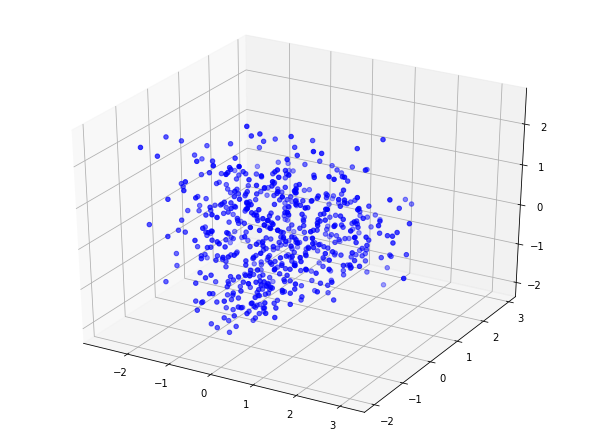

0.298917293548584


In [ ]:
start_time = time.time()
make_3d_visualization(uni_users, model, color='blue')
print(time.time() - start_time)

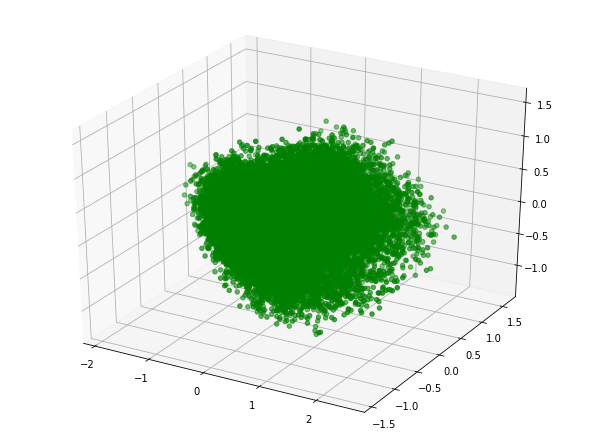

0.9095041751861572


In [ ]:
start_time = time.time()
make_3d_visualization(uni_tracks, model, color='green')
print(time.time() - start_time)

In [ ]:
embst = model.get_embeddings(uni_tracks) 
embs_3dt = PCA(n_components=3).fit_transform(np.array([i for i in embst]))
embsu = model.get_embeddings(uni_users) 
embs_3du = PCA(n_components=3).fit_transform(np.array([i for i in embsu]))

fig = plt.figure(figsize = (10, 7))
ax = Axes3D(fig)
ax.scatter3D(embs_3dt[:,0], embs_3dt[:,1], embs_3dt[:,2], s=50, color='green')
ax.scatter3D(embs_3du[:,0], embs_3du[:,1], embs_3du[:,2], s=50, color='blue')
plt.show()



---

# __REC_SYSTEMS__ content based (+ на основе неявной оценки (popularity))

---



In [ ]:
uni_tracks = list(df.track_id.unique()) 
uni_users = list(df.user_id.unique())
USER = random.choice(uni_users)

user_tracks = list(df[df.user_id==USER].track_id.values)
all_tracks = list(df.track_id.unique())
unknown_tracks = list(set(all_tracks) - set(user_tracks))
print('Пользователь --', USER)
print('Количество треков в прейлисте пользователя:', len(user_tracks))
print('Количество неизвестных пользователю треков:', len(all_tracks))

Пользователь -- 0475f8ca59a6e0ec868ec99e64657333
Количество треков в прейлисте пользователя: 82
Количество неизвестных пользователю треков: 24718




---

# RS-1 (по 3-ем "соседям" пользователя)


---



In [ ]:
USER

'05e00d07f7e7079430cb6d5372aed257'

In [ ]:
def REC_1(user):
    neighbors, dist = find_nearest_neighbours(model,
                                              entities=[USER],
                                              n_neighbors=4,
                                              entities_subset=uni_users)
    neighbors = list(neighbors[0][1:])
    neighbors_tracs = list(tr_df[(tr_df.subject==neighbors[0])
                                 |(tr_df.subject==neighbors[1])
                                 |(tr_df.subject==neighbors[2])].object.unique())
    tracks_to_rec = list(set(neighbors_tracs) - set(user_tracks))
    pops = []
    for track in tracks_to_rec:
        pops.append(list(df[df.track_id==track].popularity.unique())[0])
    rec_df = pd.DataFrame({'Tracks':tracks_to_rec, 'Popularity':pops})
    rec_df = rec_df.sort_values(by='Popularity', ascending=False)
    return rec_df.head(10)

In [ ]:
start_time = time.time()
REC_1(USER)
print(time.time() - start_time)

0.5389599800109863




---

# RS-2 (топ-10 треков, максимально похожих на те, что слушает пользователь)

---



In [ ]:
USER

'05db2293372a2e4a425b3bbfd8961fbe'

In [ ]:
def REC_2(user):
    user_tracks = list(df[df.user_id==user].track_id.values)
    all_tracks = list(df.track_id.unique())
    unknown_tracks = list(set(all_tracks) - set(user_tracks))
    rec_tracks, pops = [], []
    for track in user_tracks:
        near_track, nt_dist = find_nearest_neighbours(model,
                                                      entities=[track],
                                                      n_neighbors=1,
                                                      entities_subset=unknown_tracks)
        for t, d in zip(near_track[0], nt_dist[0]):
            rec_tracks.append(t)
            pops.append(list(df[df.track_id==t].popularity.unique())[0])
            unknown_tracks = list(set(unknown_tracks) - set(t))
    rec_df = pd.DataFrame({'Tracks': rec_tracks, 'Popularity': pops}).reset_index(drop=True)
    rec_df = rec_df.sort_values(by=['Popularity'], ascending=False).reset_index(drop=True)
    return rec_df.drop_duplicates(subset=['Tracks']).reset_index(drop=True).head(10)

In [ ]:
print('Топ-10 треков на основе ваших предпочтений:')
REC_2(USER)

Топ-10 треков на основе ваших предпочтений:


,Tracks,Popularity
0,Bitch Better Have My Money (by artist Rihanna),77
1,Maps (by artist Maroon 5),77
2,Clocks (by artist Coldplay),75
3,Kiss Me (by artist Ed Sheeran),75
4,Tenerife Sea (by artist Ed Sheeran),74
5,Hall of Fame (by artist The Script),73
6,Partition (by artist Beyoncé),71
7,Beautiful Now (by artist Zedd),71
8,Mess Is Mine (by artist Vance Joy),71
9,If I Were a Boy (by artist Beyoncé),70


=============================================



---

# RS по 3-ем "соседям" пользователя (KMeans)

---




In [ ]:
USER

'05db2293372a2e4a425b3bbfd8961fbe'

In [ ]:
def RS_KMeans(user):
    chosen_user = uni_users.index(user)
    X = model.get_embeddings(uni_users)
    nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X)
    indices = nbrs.kneighbors([X[chosen_user]])[1][0]

    neighbors = list()
    for i in indices[1:]:
        neighbors.append(uni_users[i])

    neighbors_tracks = list(tr_df[(tr_df.subject==neighbors[0])|(tr_df.subject==neighbors[1])|(tr_df.subject==neighbors[2])].object.unique())
    tracks_to_rec = list(set(neighbors_tracks) - set(user_tracks))
    pops = []
    for track in tracks_to_rec:
        pops.append(list(df[df.track_id==track].popularity.unique())[0])
    rec_df = pd.DataFrame({'Tracks':tracks_to_rec, 'Popularity':pops})
    rec_df = rec_df.sort_values(by='Popularity', ascending=False)
    return rec_df.head(10)

In [ ]:
RS_KMeans(USER)

,Tracks,Popularity
2,All of Me (by artist John Legend),85
8,Demons (by artist Imagine Dragons),74
10,Work REMIX (by artist A$AP Ferg),73
0,The Days (by artist Avicii),69
3,"Welcome Home, Son (by artist Radical Face)",68
1,Hold Back The River (by artist James Bay),67
4,Retrograde (by artist James Blake),63
5,Berlin (by artist RY X),60
7,1234 (by artist Feist),60
9,22 (by artist Taylor Swift),60
